# Task
Произвести сегментацию самолётов.

In [ ]:
from tensorflow.keras.models import Model       
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout # Импортируем стандартные слои keras
from tensorflow.keras import backend as K       
from tensorflow.keras.optimizers import Adam    
from tensorflow.keras import utils              
from google.colab import files                  
import matplotlib.pyplot as plt                
from tensorflow.keras.preprocessing import image
import numpy as np                              
from sklearn.model_selection import train_test_split
import time
import random
import os                                      
from PIL import Image                             

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**Объявление глобальных параметров**

In [ ]:
img_width =     176 # thumbnail images width
img_height =    320 # thumbnail images heigth
directory =     '/content/drive/MyDrive/Базы/База/Airplane' #
num_classes =   2 # count of classes

**Оригинальные изображения**

In [ ]:
images_airplane = []    # empty list for original airplane of train

cur_time = time.time()  # start count

for filename in sorted(os.listdir(directory)):
  images_airplane.append(image.load_img(os.path.join(directory,filename),
                      target_size = (img_width,img_height)))#read orig. img. and add to list
print('train is downloaded. Time: ', time.time() - cur_time, 'c', sep = ' ')

train is downloaded. Time:  824.8441746234894 c


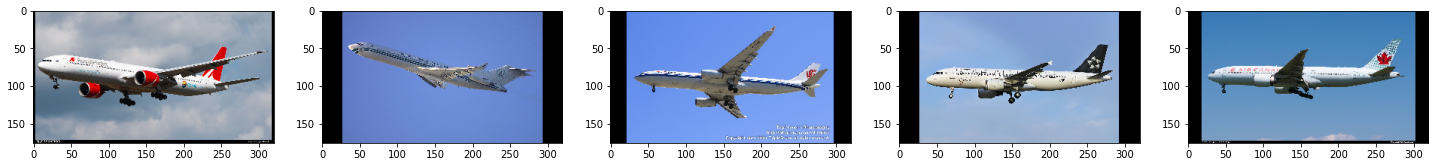

In [ ]:
n = 5                                       # number of shown images
fig,axs = plt.subplots(1,n, figsize = (25,5))#table for images

for i in range(n):
  img = random.choice(images_airplane)       #random choice of img
  axs[i].imshow(img)                        #show img on its place
plt.show()  

**Сегментированные изображения**

In [ ]:
segments_airplane = []
cur_time = time.time()  # start count
directory_sigm = '/content/drive/MyDrive/Базы/База/Segment'

for filename in sorted(os.listdir(directory_sigm)):
  segments_airplane.append(image.load_img(os.path.join(directory_sigm,filename),
                      target_size = (img_width,img_height)))#read orig. img. and add to list
print('train is downloaded. Time: ', time.time() - cur_time, 'c', sep = ' ')

train is downloaded. Time:  786.3613684177399 c


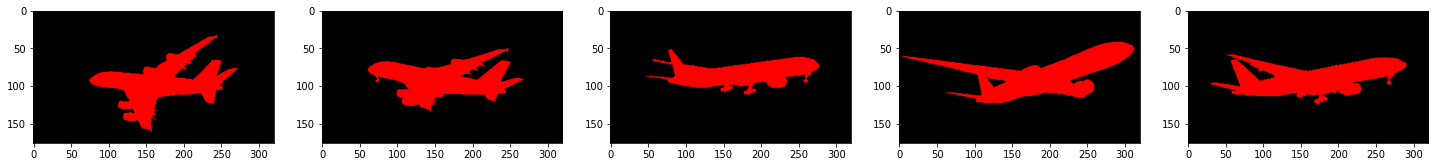

In [ ]:
n = 5                                         # number of shown images
fig,axs = plt.subplots(1,n, figsize = (25,5)) #table for images

for i in range(n):
  img = random.choice(segments_airplane)      #random choice of img
  axs[i].imshow(img)                          #show img on its place
plt.show()  

In [ ]:
fig.savefig('yourfilename.png')

# Predprocessing

In [ ]:
####################################################################################
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса).
####################################################################################

def color2index(color):
  index = 0
  if (color[0] + color[1] + color[2]) > 20 : index = 1 # if even little mark -> plane
  return index

In [ ]:
################################################
# Функция преобразования индекса в цвет пикселя.
################################################

def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0,0,0]     # -> background
  elif index == 1:
    color = [255,0,0]   # -> plane
  return color

In [ ]:
#############################################################################
# Функция преобразования трехканального пикслея в to_categorical по индексу.
#############################################################################

def rgbToohe(y, num_classes): 

    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3)

    yt = [] # Лист для ряда OHE
    
    # Переводим трёхканальные пиксели в индексы и преобразуем в OHE
    for i in range(len(y)): 
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    
    yt = np.array(yt)
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру

    return yt # Возвращаем сформированный массив

In [ ]:
##############################
# Функция формирования yTrain.
##############################

def yt_prep(data, num_classes):
    yTrain = []                               # empty list for segmentation map
    for seg in data:                          # go to all segm. imgs 
        y = image.img_to_array(seg)           # -> numpy with shape (height - widght - chanels)
        y = rgbToohe(y, num_classes)          # Ohe
        yTrain.append(y) # 
        if len(yTrain) % 100 == 0:            # each 100 steps
            print(len(yTrain)) # 
    return np.array(yTrain) # 

Формируем xTrain и xVal

In [ ]:
xTrain = []                                 # Создаем пустой список под обучающую выборку
for img in images_airplane: 
    x = image.img_to_array(img)             # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x)                        # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain)                   # Переводим в numpy
print(xTrain.shape)                         # Размерность обучающей выборки

(1000, 176, 320, 3)


Формируем yTrain

In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane,num_classes)
print('Время работыЖ ', round(time.time(),2),'c')

100
200
300
400
500
600
700
800
900
1000
Время работыЖ  1629313652.76 c


**Получаем выборки для обучения и валидации**

In [ ]:
# create train/test -> 0.9/0.1 
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)
print(y_train.shape)
print(y_val.shape)

(900, 176, 320, 2)
(100, 176, 320, 2)


# Modelling

## NN1

In [ ]:

def psp(num_classes = 3, input_shape= (88, 120, 3)):
  img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

# Start_Block
  x = Conv2D(32,(3,3),padding='same',name ='B1_Conv1')(img_input)
  x = Activation('relu')(x)
  x = Conv2D(32,(3,3),padding='same',name ='B1_Conv2')(x)    

# MaxPooling pyramid
  B1_out = MaxPooling2D((2,2))(x)
  B2_out = MaxPooling2D((4,4))(x)
  B3_out = MaxPooling2D((8,8))(x)

  # Conv layers
  B1_out = Conv2D(16,(3,3),padding='same',activation='relu')(B1_out)
  B2_out = Conv2D(16,(3,3),padding='same',activation='relu')(B2_out)
  B3_out = Conv2D(16,(3,3),padding='same',activation='relu')(B3_out)

# Transpose
  B1_out = Conv2DTranspose(16,(3,3),strides=(2,2),padding='same',activation='relu')(B1_out)
  B2_out = Conv2DTranspose(16,(3,3),strides=(4,4),padding='same',activation='relu')(B2_out)
  B3_out = Conv2DTranspose(16,(3,3),strides=(8,8),padding='same',activation='relu')(B3_out)

# Concatenate
  out = concatenate([B1_out,B2_out,B3_out])

# Finish
  out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

  model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'out'

    # Компилируем модель 
  model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
  return model # Возвращаем сформированную модель

In [ ]:


'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей



In [ ]:
modelAir = psp(2, (img_width, img_height,3))
history = modelAir.fit(x_train, y_train, epochs=15, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

Epoch 1/15
57/57 [==============================] - 12s 200ms/step - loss: 1.1946 - dice_coef: 0.7800 - val_loss: 0.2111 - val_dice_coef: 0.8625
Epoch 2/15
57/57 [==============================] - 11s 195ms/step - loss: 0.2087 - dice_coef: 0.8694 - val_loss: 0.1541 - val_dice_coef: 0.9008
Epoch 3/15
57/57 [==============================] - 11s 195ms/step - loss: 0.1496 - dice_coef: 0.9097 - val_loss: 0.1162 - val_dice_coef: 0.9316
Epoch 4/15
57/57 [==============================] - 11s 195ms/step - loss: 0.1271 - dice_coef: 0.9259 - val_loss: 0.1058 - val_dice_coef: 0.9368
Epoch 5/15
57/57 [==============================] - 11s 195ms/step - loss: 0.1245 - dice_coef: 0.9268 - val_loss: 0.1065 - val_dice_coef: 0.9387
Epoch 6/15
57/57 [==============================] - 11s 194ms/step - loss: 0.1189 - dice_coef: 0.9300 - val_loss: 0.0955 - val_dice_coef: 0.9416
Epoch 7/15
57/57 [==============================] - 11s 195ms/step - loss: 0.1101 - dice_coef: 0.9338 - val_loss: 0.0909 - val_dic

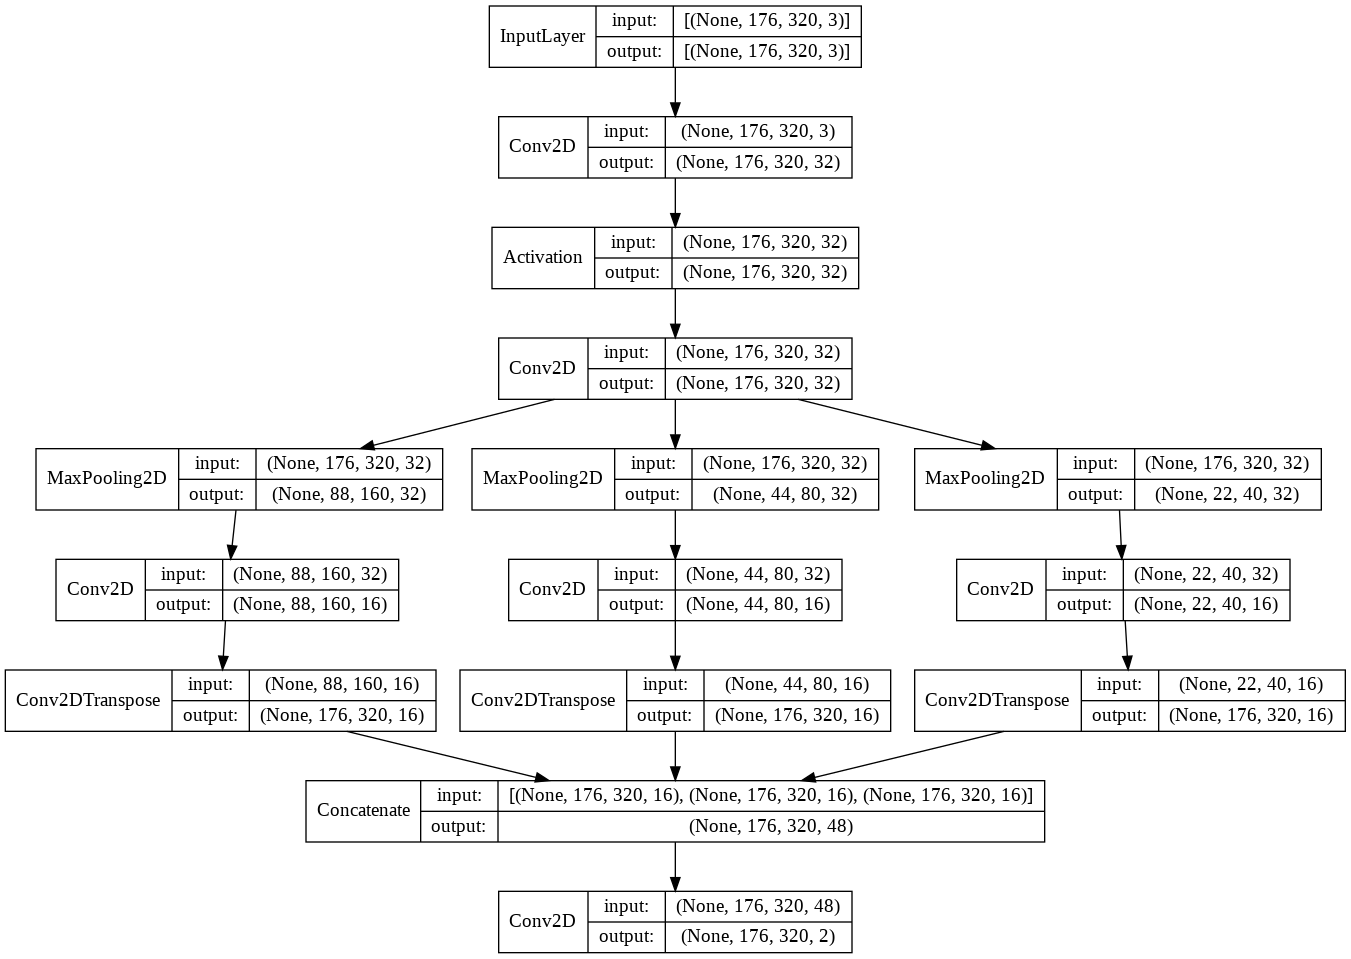

In [ ]:
utils.plot_model(modelAir,show_shapes=True,show_layer_names=False)

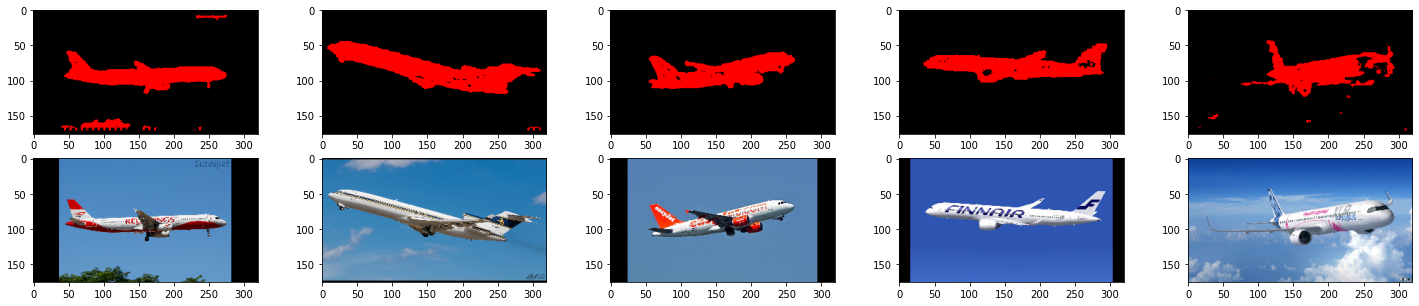

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

## NN2

Epoch 1/15
29/29 [==============================] - 28s 729ms/step - loss: 1.1074 - dice_coef: 0.7699 - val_loss: 0.5931 - val_dice_coef: 0.8397
Epoch 2/15
29/29 [==============================] - 21s 714ms/step - loss: 0.2157 - dice_coef: 0.8563 - val_loss: 0.6633 - val_dice_coef: 0.8811
Epoch 3/15
29/29 [==============================] - 21s 714ms/step - loss: 0.1505 - dice_coef: 0.9048 - val_loss: 0.3386 - val_dice_coef: 0.9264
Epoch 4/15
29/29 [==============================] - 21s 713ms/step - loss: 0.1211 - dice_coef: 0.9252 - val_loss: 0.2168 - val_dice_coef: 0.9381
Epoch 5/15
29/29 [==============================] - 21s 713ms/step - loss: 0.1158 - dice_coef: 0.9308 - val_loss: 0.1387 - val_dice_coef: 0.9482
Epoch 6/15
29/29 [==============================] - 21s 714ms/step - loss: 0.1031 - dice_coef: 0.9394 - val_loss: 0.1213 - val_dice_coef: 0.9529
Epoch 7/15
29/29 [==============================] - 21s 716ms/step - loss: 0.0959 - dice_coef: 0.9444 - val_loss: 0.1069 - val_dic

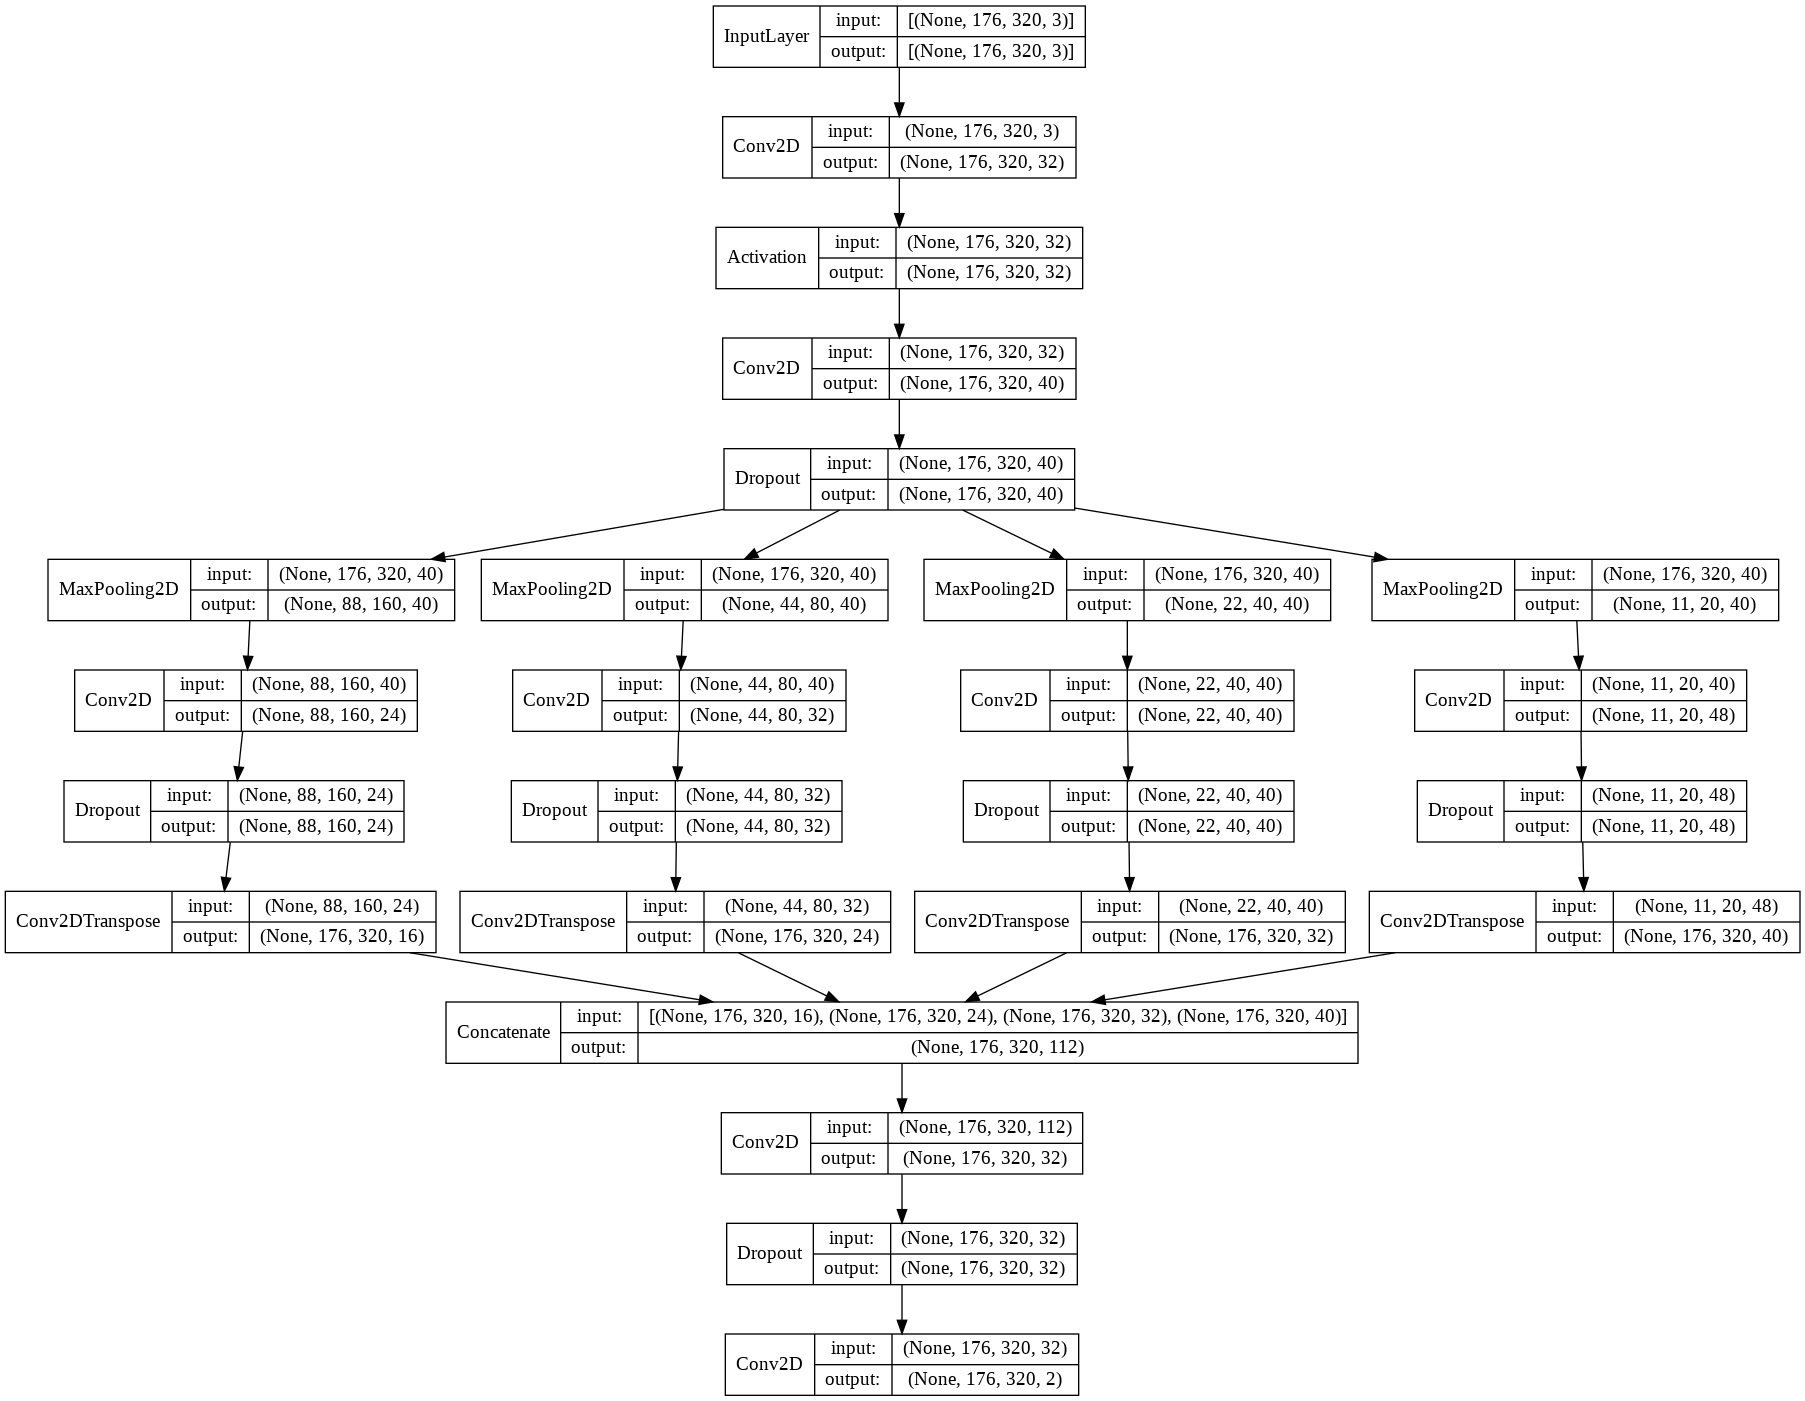

In [ ]:

def psp(num_classes = 3, input_shape= (88, 120, 3)):
  img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

# Start_Block
  x = Conv2D(32,(3,3),padding='same',name ='B1_Conv1')(img_input)
  x = Activation('relu')(x)
  x = Conv2D(40,(3,3),padding='same',name ='B1_Conv2')(x)
  x = Dropout(0.1)(x)    

# MaxPooling pyramid
  B1_out = MaxPooling2D((2,2))(x)
  B2_out = MaxPooling2D((4,4))(x)
  B3_out = MaxPooling2D((8,8))(x)
  B4_out = MaxPooling2D((16,16))(x)

  # Conv layers
  B1_out = Conv2D(24,(3,3),padding='same',activation='relu')(B1_out)
  B1_out = Dropout(0.05)(B1_out) 
  B2_out = Conv2D(32,(3,3),padding='same',activation='relu')(B2_out)
  B2_out = Dropout(0.05)(B2_out) 
  B3_out = Conv2D(40,(3,3),padding='same',activation='relu')(B3_out)
  B3_out = Dropout(0.1)(B3_out) 
  B4_out = Conv2D(48,(3,3),padding='same',activation='relu')(B4_out)
  B4_out = Dropout(0.1)(B4_out) 

# Transpose
  B1_out = Conv2DTranspose(16,(3,3),strides=(2,2),padding='same',activation='relu')(B1_out)
  B2_out = Conv2DTranspose(24,(3,3),strides=(4,4),padding='same',activation='relu')(B2_out)
  B3_out = Conv2DTranspose(32,(3,3),strides=(8,8),padding='same',activation='relu')(B3_out)
  B4_out = Conv2DTranspose(40,(3,3),strides=(16,16),padding='same',activation='relu')(B4_out)

# Concatenate
  out = concatenate([B1_out,B2_out,B3_out,B4_out])

# Finish

  out = Conv2D(32,(3,3),padding='same',name ='Bf_Conv2')(out)  
  out = Dropout(0.15)(out) 

  out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

  model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'out'

    # Компилируем модель 
  model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
  return model # Возвращаем сформированную модель


modelAir = psp(2, (img_width, img_height,3))
history = modelAir.fit(x_train, y_train, epochs=15, batch_size=32, validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

utils.plot_model(modelAir,show_shapes=True,show_layer_names=False)

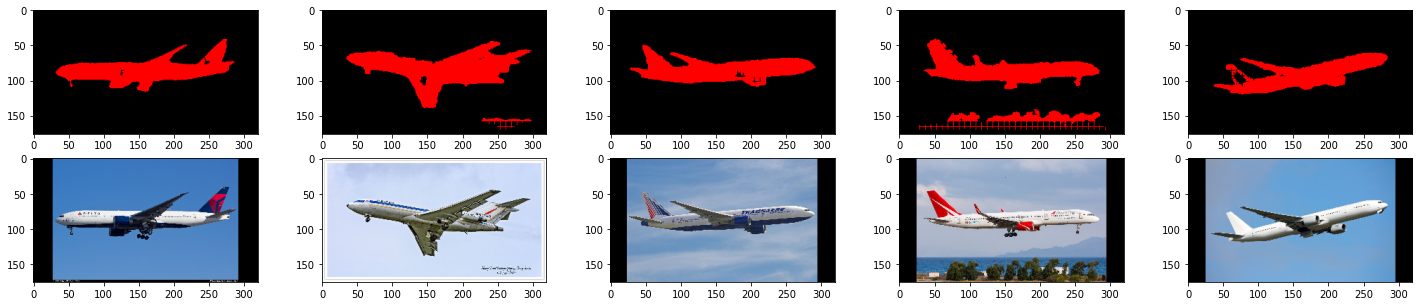

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 